In [1]:
import networkx as nx
import time
import sympy
import matplotlib.pyplot as plt

import requests
from bs4 import BeautifulSoup
from IPython.display import Markdown, display

# Really interesting puzzle and plenty of info online
# mostly as it was used as an NRICH puzzle
# https://nrich.maths.org/factorsandmultiples
# A few resources below 
#
# https://theorie.ikp.physik.tu-darmstadt.de/qcd/numchain.pdf
# https://math.dartmouth.edu/~carlp/divisorgraph.pdf
# https://arxiv.org/pdf/1807.07783.pdf
# http://www.m-hikari.com/imf-2010/37-40-2010/aladdasiIMF37-40-2010.pdf
    

In [2]:
url='https://www.janestreet.com/puzzles/chain-reaction-index/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
y =[text for text in soup.body.stripped_strings]
#display([(i,j) for i,j in enumerate(y)])
display(Markdown("### "+y[8]+"\n\n"+str("\n".join(y[10:13]))))

### July 2014 : Puzzle

Write down a chain of integers between 1 and 100, with no repetition, such that
if x and y are consecutive numbers in the chain, then x evenly divides y or y
evenly divides x. Here is an example of such a chain, with length 12:
37, 74, 2, 8, 4, 16, 48, 6, 3, 9, 27, 81
What is the longest chain you can find?

In [3]:
primes = list(sympy.primerange(0, 100))

# Question is to find the longest simple path on the divisor graph of the integers up to 100

# loop through all paths in numbs between a and b and find the longest
def longest_simple_path(numbs,a = 0,b = 0 ):
    g = nx.Graph()
    if a == 0:
        a = numbs[0]
    if b == 0:
        b = numbs[-1]
    numbs.sort()
    #print(numbs,a,b)
    
    for i in range(len(numbs)):
        for j in range(i+1,len(numbs)):
            if numbs[j] % numbs[i] == 0:
                g.add_edge(numbs[i],numbs[j])
    
    longest_paths = []
    longest_path_length = 0
    for path in nx.all_simple_paths(g,a,b):
        if len(path) > longest_path_length:
            #print("longest is now",len(path),end=" ")
            longest_path_length = len(path)
            longest_paths.clear()
            longest_paths.append(path)
    return longest_paths[0]
           
# add in the longest sequence around number n entering at a and leaving at b
def bring_in(n,a,b,sequence):
    raw = [i*n for i in range(1,50) if i*n <101 and i*n in sequence]
    series = longest_simple_path(raw,n*a,n*b)
    print("Adding {} uses {} of the {} available. Start: {} End: {}. Miss {}".format(n,len(series),len(raw),series[0],series[-1],[i for i in raw if i not in series]))
    return series

# final check. Make sure a/b or b/a works and output the omitted numbers.
def left(x,give_up):
    sequence = [*range(1,101)]
    [sequence.remove(i) for i in give_up]
    [sequence.remove(i) for i in x]
    for i in range(1,len(x)):
        if (x[i] % x[i-1] !=0) & (x[i-1] % x[i] !=0):
            print("FAIL",x[i], x[i-1])
    return sequence
    
print(primes)

[2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97]


In [4]:
# based largely on the logic here https://theorie.ikp.physik.tu-darmstadt.de/qcd/numchain.pdf
# Both the solution in this paper and the Jane St solution have similar logic but make different choices on ordering and links
# This was also a puzzle on 538 and there are 2 solutions one of which links 9-8 to form the bridge between 7 and 11 rathr than 6-9
# Finding the longest path on the large graph is too hard but if you break it down into areas it becomes solveable.

start = time.time()
# start with the list of integers
sequence = [*range(1,101)]

# give up on primes 37+ and their multiples
give_up = [i*j for i in sympy.primerange(32, 100) for j in [1,2] if i*j <101]
[sequence.remove(i) for i in give_up]

print("After removing large primes there are {} left".format(len(sequence)))

# for primes above 13 [17,19,23,29,31] use up  4,3,2,1 to capture as many multiples as possible finishing at 19 or 17 so I can use 5 to link to 13
prime_series =[i*j for i in [1,*sympy.primerange(14,32)] for j in [1,2,3,4] if i*j < 101]
prime_ordered = longest_simple_path(prime_series,17*3,19)
[sequence.remove(i) for i in prime_ordered]

print("The are {} in the prime sequence ".format(len(prime_series)))
print("The longest sequence is {} long. Miss {}".format(len(prime_ordered),[i for i in prime_series if i not in prime_ordered]))

# bring in multiples of 13 using 5 to link to 17/19 and use 6 at the end to maximise the length
link_1 = [19*5,5]
[sequence.remove(i) for i in link_1]
series_13 = bring_in(13,5,6,sequence)
[sequence.remove(i) for i in series_13]

#link between 6 and 9 
link_2=[6, 36, 18, 54, 27, 81, 9]
[sequence.remove(i) for i in link_2]

# bring in multiples of 7 using 9/10 ... starting or ending with 6 doesn't work
series_7 = bring_in(7,9,10,sequence)
[sequence.remove(i) for i in series_7]

# bring in multiples of 11 by using 8 at the start
series_11 = bring_in(11,8,5,sequence)  # can have choose either 5 or 7 at the end
[sequence.remove(i) for i in series_11]

# find the longest path between 10 and 8 in the rest
rest= longest_simple_path(sequence,10,8)
[sequence.remove(i) for i in rest]


print("\nFinal Sequence")
print("~~~~~~~~~~~~~~")
final_sequence = prime_ordered+link_1+series_13+link_2+series_7+rest+series_11
print(final_sequence)
print("\nLength is {}".format(len(set(final_sequence))))
print("Took {:.2f} seconds".format(time.time()-start))
print("\nNumbers left")
print(left(final_sequence,give_up))

print("\nELEMENTS")
print(prime_ordered)
print(link_1)
print(series_13)
print(link_2)
print(series_7)
print(rest)
print(series_11)


After removing large primes there are 82 left
The are 22 in the prime sequence 
The longest sequence is 21 long. Miss [57]
Adding 13 uses 5 of the 7 available. Start: 65 End: 78. Miss [39, 91]
Adding 7 uses 12 of the 14 available. Start: 63 End: 70. Miss [77, 91]
Adding 11 uses 8 of the 9 available. Start: 88 End: 55. Miss [77]

Final Sequence
~~~~~~~~~~~~~~
[51, 17, 34, 68, 1, 87, 29, 58, 2, 62, 31, 93, 3, 69, 23, 46, 92, 4, 76, 38, 19, 95, 5, 65, 13, 52, 26, 78, 6, 36, 18, 54, 27, 81, 9, 63, 21, 42, 84, 28, 56, 14, 98, 49, 7, 35, 70, 10, 20, 100, 50, 25, 75, 15, 45, 90, 30, 60, 12, 72, 24, 48, 96, 32, 64, 16, 80, 40, 8, 88, 44, 22, 66, 33, 99, 11, 55]

Length is 77
Took 0.91 seconds

Numbers left
[39, 57, 77, 85, 91]

ELEMENTS
[51, 17, 34, 68, 1, 87, 29, 58, 2, 62, 31, 93, 3, 69, 23, 46, 92, 4, 76, 38, 19]
[95, 5]
[65, 13, 52, 26, 78]
[6, 36, 18, 54, 27, 81, 9]
[63, 21, 42, 84, 28, 56, 14, 98, 49, 7, 35, 70]
[10, 20, 100, 50, 25, 75, 15, 45, 90, 30, 60, 12, 72, 24, 48, 96, 32, 64, 16

In [5]:
url='https://www.janestreet.com/puzzles/chain-reaction-solution/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
y =[text for text in soup.body.stripped_strings]
#display([(i,j) for i,j in enumerate(y)])
display(Markdown("### "+y[8]+"\n\n"+str("\n".join(y[10:11]))))

### July 2014 : Solution

Tough, open-ended puzzle this month! Many came close, but we received 7
submissions with chains of length 77, which is also the longest we could find.
Congratulations to Alexander Chappell, one of the 7, and this month’s randomly
chosen winner of a Jane Street t-shirt! His submission was: 69 23 46 92 4 76 38
19 95 5 85 17 68 34 2 62 31 93 3 87 29 58 1 49 98 14 56 28 84 42 21 63 9 81 27
54 18 72 36 12 6 66 33 99 11 22 44 88 8 24 48 96 32 64 16 80 40 20 60 30 90 45
15 75 25 100 50 10 70 35 7 91 13 39 78 26 52

In [6]:
# the Jane st and paper solutions
soln1 = [62, 31, 93, 1, 87, 29, 58, 2, 46, 92, 23, 69, 3, 57, 19, 38, 76, 4, 68,
         34, 17, 85, 5, 65, 13, 52, 26, 78, 6, 36, 18, 54, 27, 81, 9, 63, 21, 42, 
         84, 28, 56, 14, 98, 49, 7, 35, 70, 10, 40, 80, 20, 100, 50, 25, 75, 15, 45,
         90, 30, 60, 12, 72, 24, 48, 16, 96, 32, 64, 8, 88, 44, 22, 66, 33, 99, 11, 55]

soln2 = [69, 23, 46, 92, 4, 76, 38, 19, 95, 5, 85, 17, 68, 34, 2, 62, 31, 93, 3, 87, 29,
         58, 1, 49, 98, 14, 56, 28, 84, 42, 21, 63, 9, 81, 27, 54, 18, 72, 36, 12, 6, 66,
         33, 99, 11, 22, 44, 88, 8, 24, 48, 96, 32, 64, 16, 80, 40, 20, 60, 30, 90, 45, 15,
         75, 25, 100, 50, 10, 70, 35, 7, 91, 13, 39, 78, 26, 52]

# 2 from https://fivethirtyeight.com/features/is-this-bathroom-occupied/
soln3 = [62, 31, 93, 3, 69, 23, 46, 92, 4, 76, 38, 19, 95, 5, 65, 13, 52, 26, 78, 6, 48,
         96, 32, 64, 16, 80, 10, 70, 35, 7, 49, 98, 14, 56, 28, 84, 42, 21, 63, 9, 81, 27,
         54, 18, 36, 72, 24, 12, 60, 30, 90, 45, 15, 75, 25, 50, 100, 20, 40, 8, 88, 44, 22,
         66, 33, 99, 11, 55, 1, 87, 29, 58, 2, 68, 34, 17, 85]

soln4 =[93, 31, 62, 1, 87, 29, 58, 2, 92, 46, 23, 69, 3, 57, 19, 38, 76, 4, 68, 34, 17, 85,
        5, 35, 70, 10, 100, 50, 25, 75, 15, 45, 90, 30, 60, 20, 40, 80, 16, 64, 32, 96, 48,
        24, 12, 6, 78, 26, 52, 13, 91, 7, 49, 98, 14, 56, 28, 84, 42, 21, 63, 9, 81, 27, 54,
        18, 36, 72, 8, 88, 44, 22, 66, 33, 99, 11, 55]

print(left(soln1,give_up))
print(left(soln2,give_up))
print(left(soln3,give_up))
print(left(soln4,give_up))

[39, 51, 77, 91, 95]
[51, 55, 57, 65, 77]
[39, 51, 57, 77, 91]
[39, 51, 65, 77, 95]


In [7]:
# function to look at areas round primes and the best way to use low numbers to go in and out of those sub-graphs

def links(n):
    g = nx.Graph()
    numbs = [i*j for i in range(1,100//n+1) for j in [n] if i*j <101 and i*j not in [1,2,3,4]]
    print("There are {} available".format(len(numbs)))
    for i in range(len(numbs)):
        for j in range(i+1,len(numbs)):
            if numbs[j] % numbs[i] == 0:
                g.add_edge(numbs[i],numbs[j])
    fig, ax = plt.subplots(figsize=(10,5))
    pos = nx.spring_layout(g, seed=100)  
    options = {
        "font_size": 10,
        "node_size": 300,
        "node_color": "white",
        "edgecolors": "black",
        "linewidths": 1,
        "width": 1,
        }
    nx.draw_networkx(g, pos, **options)
   
    for a in range(5,min(100//n,11)):
        for b in range(a+1,min(100//n+1,11)):
            longest_paths = []
            longest_path_length = 0
            for path in nx.all_simple_paths(g,a*n,b*n):
                if len(path) > longest_path_length:
                    longest_path_length = len(path)
                    longest_paths.clear()
                    longest_paths.append(path)
            print("For {}-{} ({}-{}) longest path length is {}".format(a,b,a*n,b*n,len(longest_paths[0])))

There are 7 available
For 5-6 (65-78) longest path length is 5
For 5-7 (65-91) longest path length is 3
For 6-7 (78-91) longest path length is 5


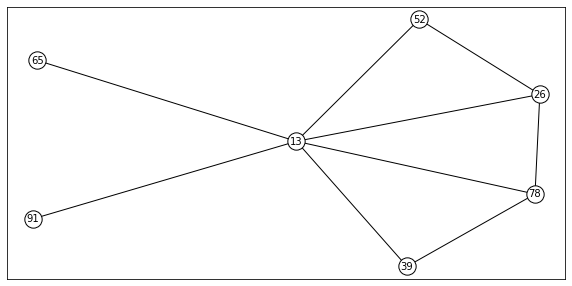

In [8]:
links(13)

There are 9 available
For 5-6 (55-66) longest path length is 6
For 5-7 (55-77) longest path length is 3
For 5-8 (55-88) longest path length is 8
For 5-9 (55-99) longest path length is 8
For 6-7 (66-77) longest path length is 6
For 6-8 (66-88) longest path length is 7
For 6-9 (66-99) longest path length is 7
For 7-8 (77-88) longest path length is 8
For 7-9 (77-99) longest path length is 8
For 8-9 (88-99) longest path length is 7


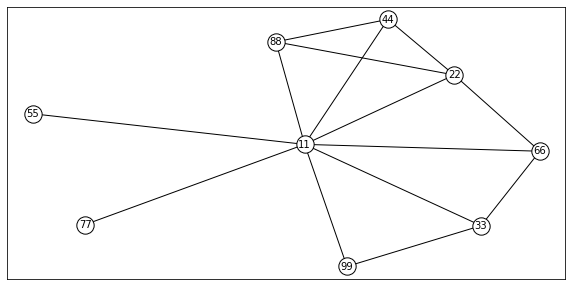

In [9]:
links(11)

There are 14 available
For 5-6 (35-42) longest path length is 11
For 5-7 (35-49) longest path length is 12
For 5-8 (35-56) longest path length is 12
For 5-9 (35-63) longest path length is 12
For 5-10 (35-70) longest path length is 10
For 6-7 (42-49) longest path length is 11
For 6-8 (42-56) longest path length is 10
For 6-9 (42-63) longest path length is 10
For 6-10 (42-70) longest path length is 11
For 7-8 (49-56) longest path length is 12
For 7-9 (49-63) longest path length is 12
For 7-10 (49-70) longest path length is 12
For 8-9 (56-63) longest path length is 10
For 8-10 (56-70) longest path length is 11
For 9-10 (63-70) longest path length is 12


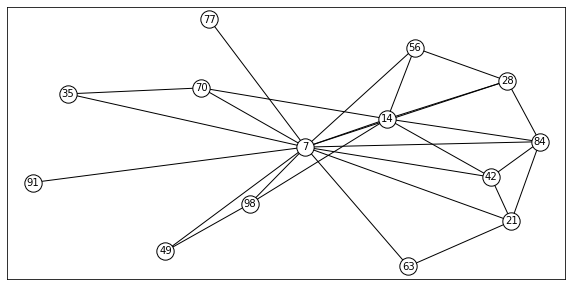

In [10]:
links(7)

There are 20 available
For 5-6 (25-30) longest path length is 15
For 5-7 (25-35) longest path length is 16
For 5-8 (25-40) longest path length is 16
For 5-9 (25-45) longest path length is 16
For 5-10 (25-50) longest path length is 16
For 6-7 (30-35) longest path length is 16
For 6-8 (30-40) longest path length is 16
For 6-9 (30-45) longest path length is 16
For 6-10 (30-50) longest path length is 16
For 7-8 (35-40) longest path length is 16
For 7-9 (35-45) longest path length is 16
For 7-10 (35-50) longest path length is 16
For 8-9 (40-45) longest path length is 16
For 8-10 (40-50) longest path length is 16
For 9-10 (45-50) longest path length is 16


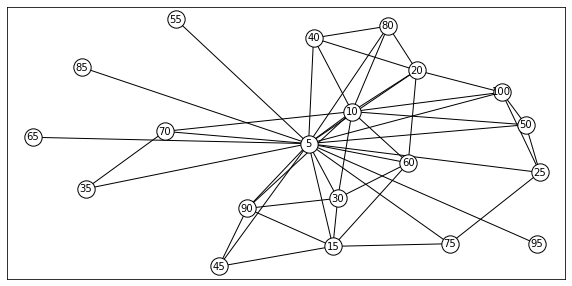

In [11]:
links(5)